# CV Coursework: Model 3: CNN on coursework dataset

- **Module:** Computer Vision - IN3060/INM460
- **Module leader:** [Giacomo Tarroni](mailto:giacomo.tarroni@city.ac.uk)
- **CW Owner:** Mousuf C Zaman - Student No: 180021356

## Google Colab & Env Setup

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy
# Modified by: Giacomo Tarroni

import torch
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

%matplotlib inline


device = torch.device("cuda:0" if torch.cuda.is_available()  else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

from google.colab import drive
drive.mount('/content/drive')

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '11 - University/Colab Notebooks/Computer Vision Lab/CW_Folder_UG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

%load_ext autoreload
%autoreload 2

import sys
MODEL_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Models')
sys.path.append(MODEL_PATH)

Classifier_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Code/Classifier')
sys.path.append(Classifier_PATH)

cuda:0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Code', 'CW_Dataset', 'Models', 'CV Report.docx', 'Other', 'Personal_Dataset', 'test_functions.ipynb', 'CV CW Progress.gdoc', 'CV Demo Script.gdoc', 'v29_ownTest_CNN_test_function[COMPLETED].ipynb', 'v28_CNN_test_function[Org DSet Completed].ipynb']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1: Transfer Learning

In this first part, we will learn how to train a convolutional neural network for
image classification using **transfer learning**. We have briefly encountered this concept in a previous lecture, but you can read more about it on these [note pages](https://cs231n.github.io/transfer-learning/).

Quoting these notes,

> In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

These two major transfer learning scenarios look as follows:
-  **Finetuning the CNN**: instead of random initialization, we
   initialize the network with a pretrained network, like the one that is trained on ImageNet. Since we will very likely have a different number of categories compared to the 1000 of ImageNet, we will usually need to replace the final fully-connected layer with a new one (with random weights) having the correct number of neurons. Then the rest of the training looks as usual.
-  **CNN as fixed feature extractor**: here, we will freeze the weights for all of the network except that of the final fully-connected layer, which will be replaced with a new one (with random weights and the correct number of neurons) as in the previous case. Only this layer is trained. The coding for this second approach will constitute a Task.

## Loading the Data

replace CV2023_CW_Dataset_CNN/test/0/image_2401.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CV2023_CW_Dataset_CNN/test/0/image_2402.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CV2023_CW_Dataset_CNN/test/0/image_2408.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CV2023_CW_Dataset_CNN/test/0/image_2409.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CV2023_CW_Dataset_CNN/test/0/image_2410.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CV2023_CW_Dataset_CNN/test/0/image_2443.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CV2023_CW_Dataset_CNN/test/0/image_2458.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CV2023_CW_Dataset_CNN/test/0/image_2465.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CV2023_CW_Dataset_CNN/test/0/image_2468.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CV2023_CW_Dataset_CNN/test/0/image_2470.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CV2023_CW_Dataset_CNN/test/0/image_2472.jpeg? [y]es, [n]o, [A]ll, [N]one

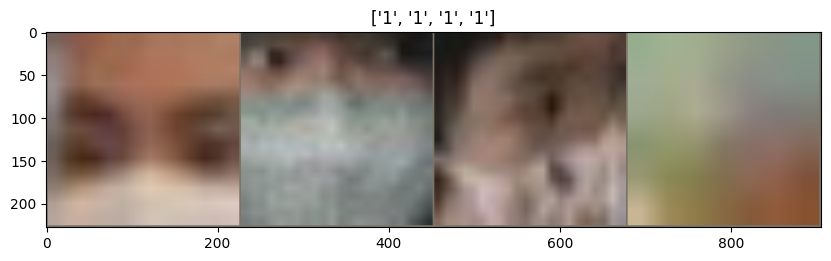

In [ ]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2023_CW_Dataset_CNN.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it (removing useless files stored in the zip)
!yes|unzip -q CV2023_CW_Dataset_CNN.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2023_CW_Dataset_CNN.zip


data_dir = 'CV2023_CW_Dataset_CNN'
data_means = [0.485, 0.456, 0.406]
data_stds = [0.229, 0.224, 0.225]

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Get a batch of training data
first_inputs, first_classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(first_inputs)

plt.figure(figsize=(10, 15))
imshow(out, title=[class_names[x] for x in first_classes])
plt.show()


## Training the model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('----------------')

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # move data to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # update learning rate with scheduler
            if phase == 'train':
                scheduler.step()

            #epoch loss and accuracy are calculated
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}")

            # deep copy the model with best accuracy on validation set
            if phase == 'test' and epoch_acc > best_acc:
                # best epoch accuracy is updated
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best test acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f"Predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])        # move back the data to the CPU for visualisation

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the CNN

In [ ]:
model_ft = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Define the number of classes in your problem
num_classes = 3

from train_CNN import train_CNN
##############################################################################
# TODO: use ResNet18 as feature extractor                                    #
##############################################################################
# Modify the model to output the desired number of classes
model_ft = train_CNN(model_ft, num_classes)

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


## Train and evaluate

In [ ]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# sets up the stochastic gradient descent optimizer to update only the parameters of the final layer.
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
torch.save(model_ft.state_dict(), 'CNN_original_Dataset.pth')

model_ft.load_state_dict(torch.load(os.path.join(MODEL_PATH,'CNN_original_Dataset.pth')))

<All keys matched successfully>

## Result

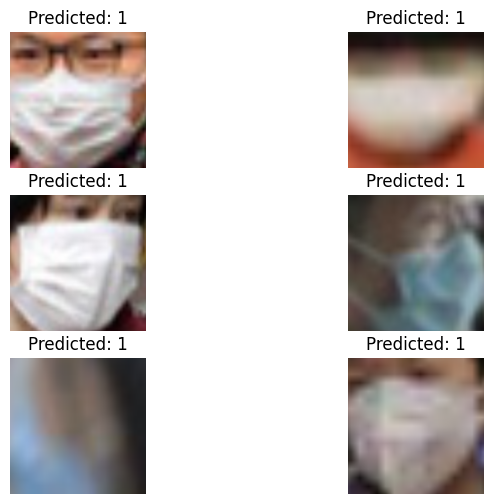

              precision    recall  f1-score   support

           0       0.89      0.76      0.82        51
           1       0.93      0.99      0.96       388
           2       0.00      0.00      0.00        19

    accuracy                           0.92       458
   macro avg       0.60      0.58      0.59       458
weighted avg       0.88      0.92      0.90       458



In [ ]:
plt.figure(figsize=(8, 6))
visualize_model(model_ft)
plt.show()

from sklearn.metrics import classification_report

# Set model to evaluate mode
model_ft.eval()

# Get predictions on test data
y_preds = []
y_true = []
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        y_preds.extend(preds.tolist())
        y_true.extend(labels.tolist())

# Compute classification report
print(classification_report(y_true, y_preds, zero_division=0))

print(f"""Classification report for classifier {model_ft}:
      {metrics.classification_report(y_own_test, y_pred, zero_division=0)}\n""")

error:

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The warning message you received is because the classification report is trying to calculate precision, recall, and F1-score for labels with no predicted samples. This is typically caused by an imbalance in the data or a classification model that is not performing well on some classes.

One way to address this issue is to use the zero_division parameter of the classification_report function. This parameter controls the behavior when a class has no predicted samples. By default, it sets the precision, recall, and F1-score to 0, but you can set it to another value or to 'warn' to show a warning message.

For example, you can modify your visualize_model function to include the zero_division parameter like this:

By setting zero_division=0, the classification report will set the precision, recall, and F1-score to 0 for classes with no predicted samples. This can help you see which classes are causing the warning message and investigate further.

You should now see the model file in the *Files* folder in the toolbar on the left side. 

PyTorch offers other ways to achieve model persistence and also provides an easy way to **load directly on CPU models that were trained on GPU** (allowing testing on machines without acceleration). To learn more about these topics, make sure to visit this [tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

Quite the improvement! Keep this in mind, in case you need reliable face detection.